# IS319 - Deep Learning

## TP2 - Dogs vs. cats (PyTorch)

Credits: Baptiste Pesquet

![Woof Meow](woof_meow.jpg)

In this TP, the goal is to train neural networks to classify images of dogs and cats, using the PyTorch library.

The images used in this TP are extracted from the [Dogs vs. Cats](https://www.kaggle.com/c/dogs-vs-cats/) dataset available on Kaggle, which contains 25000 images. First, we use a subset of 2000 images to decrease training time, for educational purposes. Later on, you can experiment with the full dataset using a GPU.

Most questions are open-ended: feel free to experiment with different settings. **Remember to analyze and explain what you are doing in additional cells.**

## Environment setup

In [1]:
import os
import zipfile
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Import PyTorch modules (edit this list if needed)
import torch
print(f'PyTorch version: {torch.__version__}')
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F

PyTorch version: 2.1.0


## 1. Load and explore the dataset

In [3]:
# Downloading our example data, a .zip of 2000 JPG pictures, and extracting it locally in `/tmp`
!wget --no-check-certificate --no-clobber \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

# Extracting zip file to the base directory `/tmp/cats_and_dogs_filtered`
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'validation')

# Directories with training/validation cat/dogs pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
valid_cats_dir = os.path.join(valid_dir, 'cats')
valid_dogs_dir = os.path.join(valid_dir, 'dogs')

# Display the sizes of our dataset
print(f'Number of train cat images: {len(os.listdir(train_cats_dir))}')
print(f'Number of train dog images: {len(os.listdir(train_dogs_dir))}')
print(f'Number of valid cat images: {len(os.listdir(valid_cats_dir))}')
print(f'Number of valid dog images: {len(os.listdir(valid_dogs_dir))}')

# Display some images files for cats and dogs
train_cat_fnames = os.listdir(train_cats_dir)
print(train_cat_fnames[:10])
train_dog_fnames = os.listdir(train_dogs_dir)
print(train_dog_fnames[:10])

valid_cat_fnames = os.listdir(valid_cats_dir)
valid_dog_fnames = os.listdir(valid_dogs_dir)

Fichier « /tmp/cats_and_dogs_filtered.zip » déjà présent ; pas de récupération.
Number of train cat images: 1000
Number of train dog images: 1000
Number of valid cat images: 500
Number of valid dog images: 500
['cat.952.jpg', 'cat.946.jpg', 'cat.6.jpg', 'cat.749.jpg', 'cat.991.jpg', 'cat.985.jpg', 'cat.775.jpg', 'cat.761.jpg', 'cat.588.jpg', 'cat.239.jpg']
['dog.775.jpg', 'dog.761.jpg', 'dog.991.jpg', 'dog.749.jpg', 'dog.985.jpg', 'dog.952.jpg', 'dog.946.jpg', 'dog.211.jpg', 'dog.577.jpg', 'dog.563.jpg']


**(Question)** Display some images of cats and dogs from the train set and the validation set.

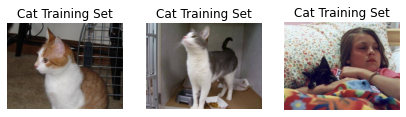

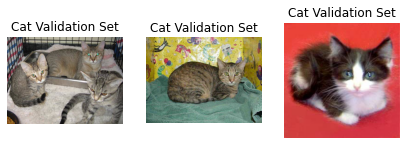

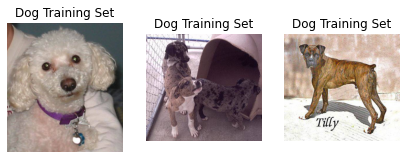

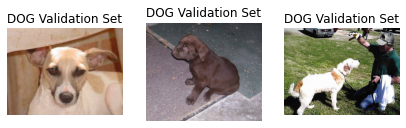

In [4]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Display some cat images from the training set
train_cat_images = [os.path.join(train_cats_dir, fname) for fname in train_cat_fnames[:3]]
plt.figure(figsize=(12, 6))
for i, image_path in enumerate(train_cat_images):
    plt.subplot(2, 5, i + 1)
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.title("Cat Training Set")
    plt.axis('off')    

# Display some cat images from the training set
valid_cat_images = [os.path.join(valid_cats_dir, fname) for fname in valid_cat_fnames[:3]]
plt.figure(figsize=(12, 6))
for i, image_path in enumerate(valid_cat_images):
    plt.subplot(2, 5, i + 1)
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.title("Cat Validation Set")
    plt.axis('off') 

# Display some dog images from the training set
train_dog_images = [os.path.join(train_dogs_dir, fname) for fname in train_dog_fnames[:3]]
plt.figure(figsize=(12, 6))
for i, image_path in enumerate(train_dog_images):
    plt.subplot(2, 5, i + 1)
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.title("Dog Training Set")
    plt.axis('off')    

# Display some cat images from the training set
valid_dog_images = [os.path.join(valid_dogs_dir, fname) for fname in valid_dog_fnames[:3]]
plt.figure(figsize=(12, 6))
for i, image_path in enumerate(valid_dog_images):
    plt.subplot(2, 5, i + 1)
    img = mpimg.imread(image_path)
    plt.imshow(img)
    plt.title("DOG Validation Set")
    plt.axis('off') 

## 2. Prepare the dataset

**(Question)** Following the documentation, create a custom `torch.utils.data.Dataset` class to handle your train and validation datasets. Allow this class to resize images and normalize them. Then, create a `DataLoader` for train and validation datasets to handle shuffling and batches.

In [5]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class CustomDataset(Dataset) :
    def __init__(self, data_dir, transform=None, shuffle=True) :
        self.data_dir = data_dir
        self.transform = transform
        self.images_path = []
        self.labels = []

        for class_name in os.listdir(data_dir) :
            class_dir = os.path.join(data_dir, class_name)
            for im in os.listdir(class_dir) :
                self.images_path.append(os.path.join(class_dir, im))
                if class_name == 'cats' :
                    self.labels.append(0)
                else :
                    self.labels.append(1)
        
        if shuffle :
            self.images_path = np.array(self.images_path)
            self.labels = np.array(self.labels)
            rng = np.random.default_rng(42)
            permutation_indices = rng.permutation(len(self.images_path))
            self.images_path = self.images_path[permutation_indices]
            self.labels = self.labels[permutation_indices]


    def __len__(self) :
        return len(self.images_path)

    def __getitem__(self, idx) :
        im_name = self.images_path[idx]
        im = Image.open(im_name)
        if self.transform :
            im = self.transform(im)
        label = self.labels[idx]
        return im, label

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])


In [6]:
train_dataset = CustomDataset(train_dir, transform=transform)
valid_dataset = CustomDataset(valid_dir, transform=transform)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

## 3. Training CNN models

**(Question)** Create a CNN classification model able to be trained on your dataset. Show the model and its number of parameters.

In [7]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 32 * 64 * 64)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = NeuralNetwork()


**(Question)** Using PyTorch, implement a training loop with your model and an appropriate loss function.

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [9]:

def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        y_pred = model(X)
        loss = loss_fn(y_pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        # if batch % 10 == 0:
        #     loss, current = loss.item(), (batch + 1) * len(X)
        #     print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")


**(Question)** Train your model. Monitor train and validation accuracy. Analyze your results.

In [10]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, optimizer)
    test_loop(valid_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 56.2%, Avg loss: 0.685527 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 54.4%, Avg loss: 0.689555 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 56.6%, Avg loss: 0.687390 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 57.9%, Avg loss: 0.676707 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 52.7%, Avg loss: 0.695106 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 60.1%, Avg loss: 0.660601 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 59.2%, Avg loss: 0.663393 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 62.5%, Avg loss: 0.651734 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 62.2%, Avg loss: 0.654896 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 58.9%, Avg loss: 0.665084 

Done!


**(Question)** Make sure your code is using a GPU if one is available. Modify your code accordingly, if necessary. What kind of speedup do you observe? 

## 4. Preventing overfitting

**(Question)** Experiment with various deep learning techniques to prevent overfitting.

Some suggested strategies are:

- Adding data augmentation: possible transformations are random (horizontal) flips, rotations, translations, crops, and zooms
    - (When using data augmentation, it is always good to visualize some of your transformations)
- Adding dropout to the classification part
- Adding appropriate batch normalization layers in different parts of the network

In [11]:
# class NeuralNetworkDropout(nn.Module):
#     def __init__(self):
#         super(NeuralNetworkDropout, self).__init__()
#         self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
#         self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.fc1 = nn.Linear(32 * 64 * 64, 128)
#         self.dropout = nn.Dropout(0.8) 
#         self.fc2 = nn.Linear(128, 2)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = x.view(-1, 32 * 64 * 64)
#         x = F.relu(self.fc1(x))
#         x = self.dropout(x)
#         x = self.fc2(x)
#         return x

# model_dropout = NeuralNetworkDropout()
# epochs = 2
# for t in range(epochs):
#     print(f"Epoch {t+1}\n-------------------------------")
#     train_loop(train_loader, model_dropout, loss_fn, optimizer)
#     test_loop(valid_loader, model_dropout, loss_fn)
# print("Done!")

In [12]:
augmentation_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

train_dataset_augmented = CustomDataset(train_dir, transform=augmentation_transform)

train_loader_augmented = DataLoader(train_dataset_augmented, batch_size=batch_size, shuffle=True)


**(Question)** Train your model with deep learning techniques. Analyze the results and compare with the previous model.

In [13]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader_augmented, model, loss_fn, optimizer)
    test_loop(valid_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 61.1%, Avg loss: 0.652737 

Epoch 2
-------------------------------
Test Error: 
 Accuracy: 59.5%, Avg loss: 0.663066 

Epoch 3
-------------------------------
Test Error: 
 Accuracy: 62.7%, Avg loss: 0.648036 

Epoch 4
-------------------------------
Test Error: 
 Accuracy: 63.9%, Avg loss: 0.639433 

Epoch 5
-------------------------------
Test Error: 
 Accuracy: 55.8%, Avg loss: 0.678738 

Epoch 6
-------------------------------
Test Error: 
 Accuracy: 59.6%, Avg loss: 0.658902 

Epoch 7
-------------------------------
Test Error: 
 Accuracy: 65.6%, Avg loss: 0.634704 

Epoch 8
-------------------------------
Test Error: 
 Accuracy: 62.7%, Avg loss: 0.644035 

Epoch 9
-------------------------------
Test Error: 
 Accuracy: 65.7%, Avg loss: 0.633173 

Epoch 10
-------------------------------
Test Error: 
 Accuracy: 61.7%, Avg loss: 0.644308 

Done!


## 5. Finetuning a pretrained model

**(Question)** Load the feature extraction part of VGG16 model. The feature extraction part corresponds to the CNN part, without the MLP classifier at the end.

In [15]:
import torchvision.models as models

vgg16 = models.vgg16(pretrained=True)
feature_extractor = vgg16.features

**(Question)** Add a custom MLP classifier on top of the VGG16 feature extraction part.

In [ ]:
class CustomClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(CustomClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

classifier = CustomClassifier(512 * 7 * 7, 256, 2)

**(Question)** Train your model. Analyze your results and compare with your initial model trained from scratch.

In [ ]:
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, classifier, loss_fn, optimizer)
    test_loop(valid_loader, classifier, loss_fn)
print("Done!")